# Prophet 응용
- holiday 추가
- 계절성을 표현하는 주기성분 바꾸기
- 조건부 계절성 설정

## Prothet의 장점
- 결측치가 있어도 동작 (결측치 구간이 길어도 된다)
- 한 샘플후나, 지정된 미래를 예측하는 것이 아니라, 전 구간을 한번에 예측해준다
- trend, seasonality 등을 시각적으로 보여준다
- holidays를 추가하여 임의의 이벤트별 특성을 반영할 수 있다.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/uamlja9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/v8d36hoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68885', 'data', 'file=/tmp/tmpnu140hf4/uamlja9b.json', 'init=/tmp/tmpnu140hf4/v8d36hoo.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_modelf3aoxslo/prophet_model-20230921012337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df[:3]

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677


## 휴일과 이벤트 반영
- `holiday`과 `ds` 컬럼을 갖는 데이터프레임을 만든다
- 과거와 미래 전체 이벤트 날짜를 담고 있어야 한다
- lower_window, upper_window를 설정할 수 있는데 휴일 전날에도 영향이 있다면 `lower_window=-1,upper_window=0`로 휴일 다음날에도 영향이있다면 `lower_window=0,upper_window=1`로 설정한다
- 각 휴일별로 `prior_scale`을 지정할 수 있다 (아래 참조)

In [5]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 0,
})   #플레이오프와
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})  #슈퍼볼 시즌의 Event 를 만들어줌. lower_window ~ upper_window : 해당 일자기준으로 전후에 며칠이나 영향을 주는지. 플레이오프는 영향X, 슈퍼볼을 그 다음날 1일후까지 영향이 있음.
holidays = pd.concat((playoffs, superbowls))

In [ ]:
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,0
1,playoff,2009-01-03,0,0
2,playoff,2010-01-16,0,0
3,playoff,2010-01-24,0,0
4,playoff,2010-02-07,0,0
5,playoff,2011-01-08,0,0
6,playoff,2013-01-12,0,0
7,playoff,2014-01-12,0,0
8,playoff,2014-01-19,0,0
9,playoff,2014-02-02,0,0


- 종류가 다른 이벤트를 구분했다, superbowl과 playoff
- 이를 `holidays` 인자로 사용한다

In [6]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/f1mgoiq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/w_1sp9yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13420', 'data', 'file=/tmp/tmpnu140hf4/f1mgoiq6.json', 'init=/tmp/tmpnu140hf4/w_1sp9yf.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_modelgbgvzdpq/prophet_model-20230921012607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:26:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


The holiday effect can be seen in the `forecast` dataframe:

In [7]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
1806,2013-01-12,1.134621,0.000000
2169,2014-01-12,1.134621,0.000000
2176,2014-01-19,1.134621,0.000000
2190,2014-02-02,1.134621,1.206116
2191,2014-02-03,0.000000,3.341747
2532,2015-01-11,1.134621,0.000000
2901,2016-01-17,1.134621,0.000000
2908,2016-01-24,1.134621,0.000000
2922,2016-02-07,1.134621,1.206116
2923,2016-02-08,0.000000,3.341747


- 컴포넌트 그래프에서 휴일 효과를 볼 수 있다
- playoff에서 나타나며 superbowl에서는 더 크게 나타난다

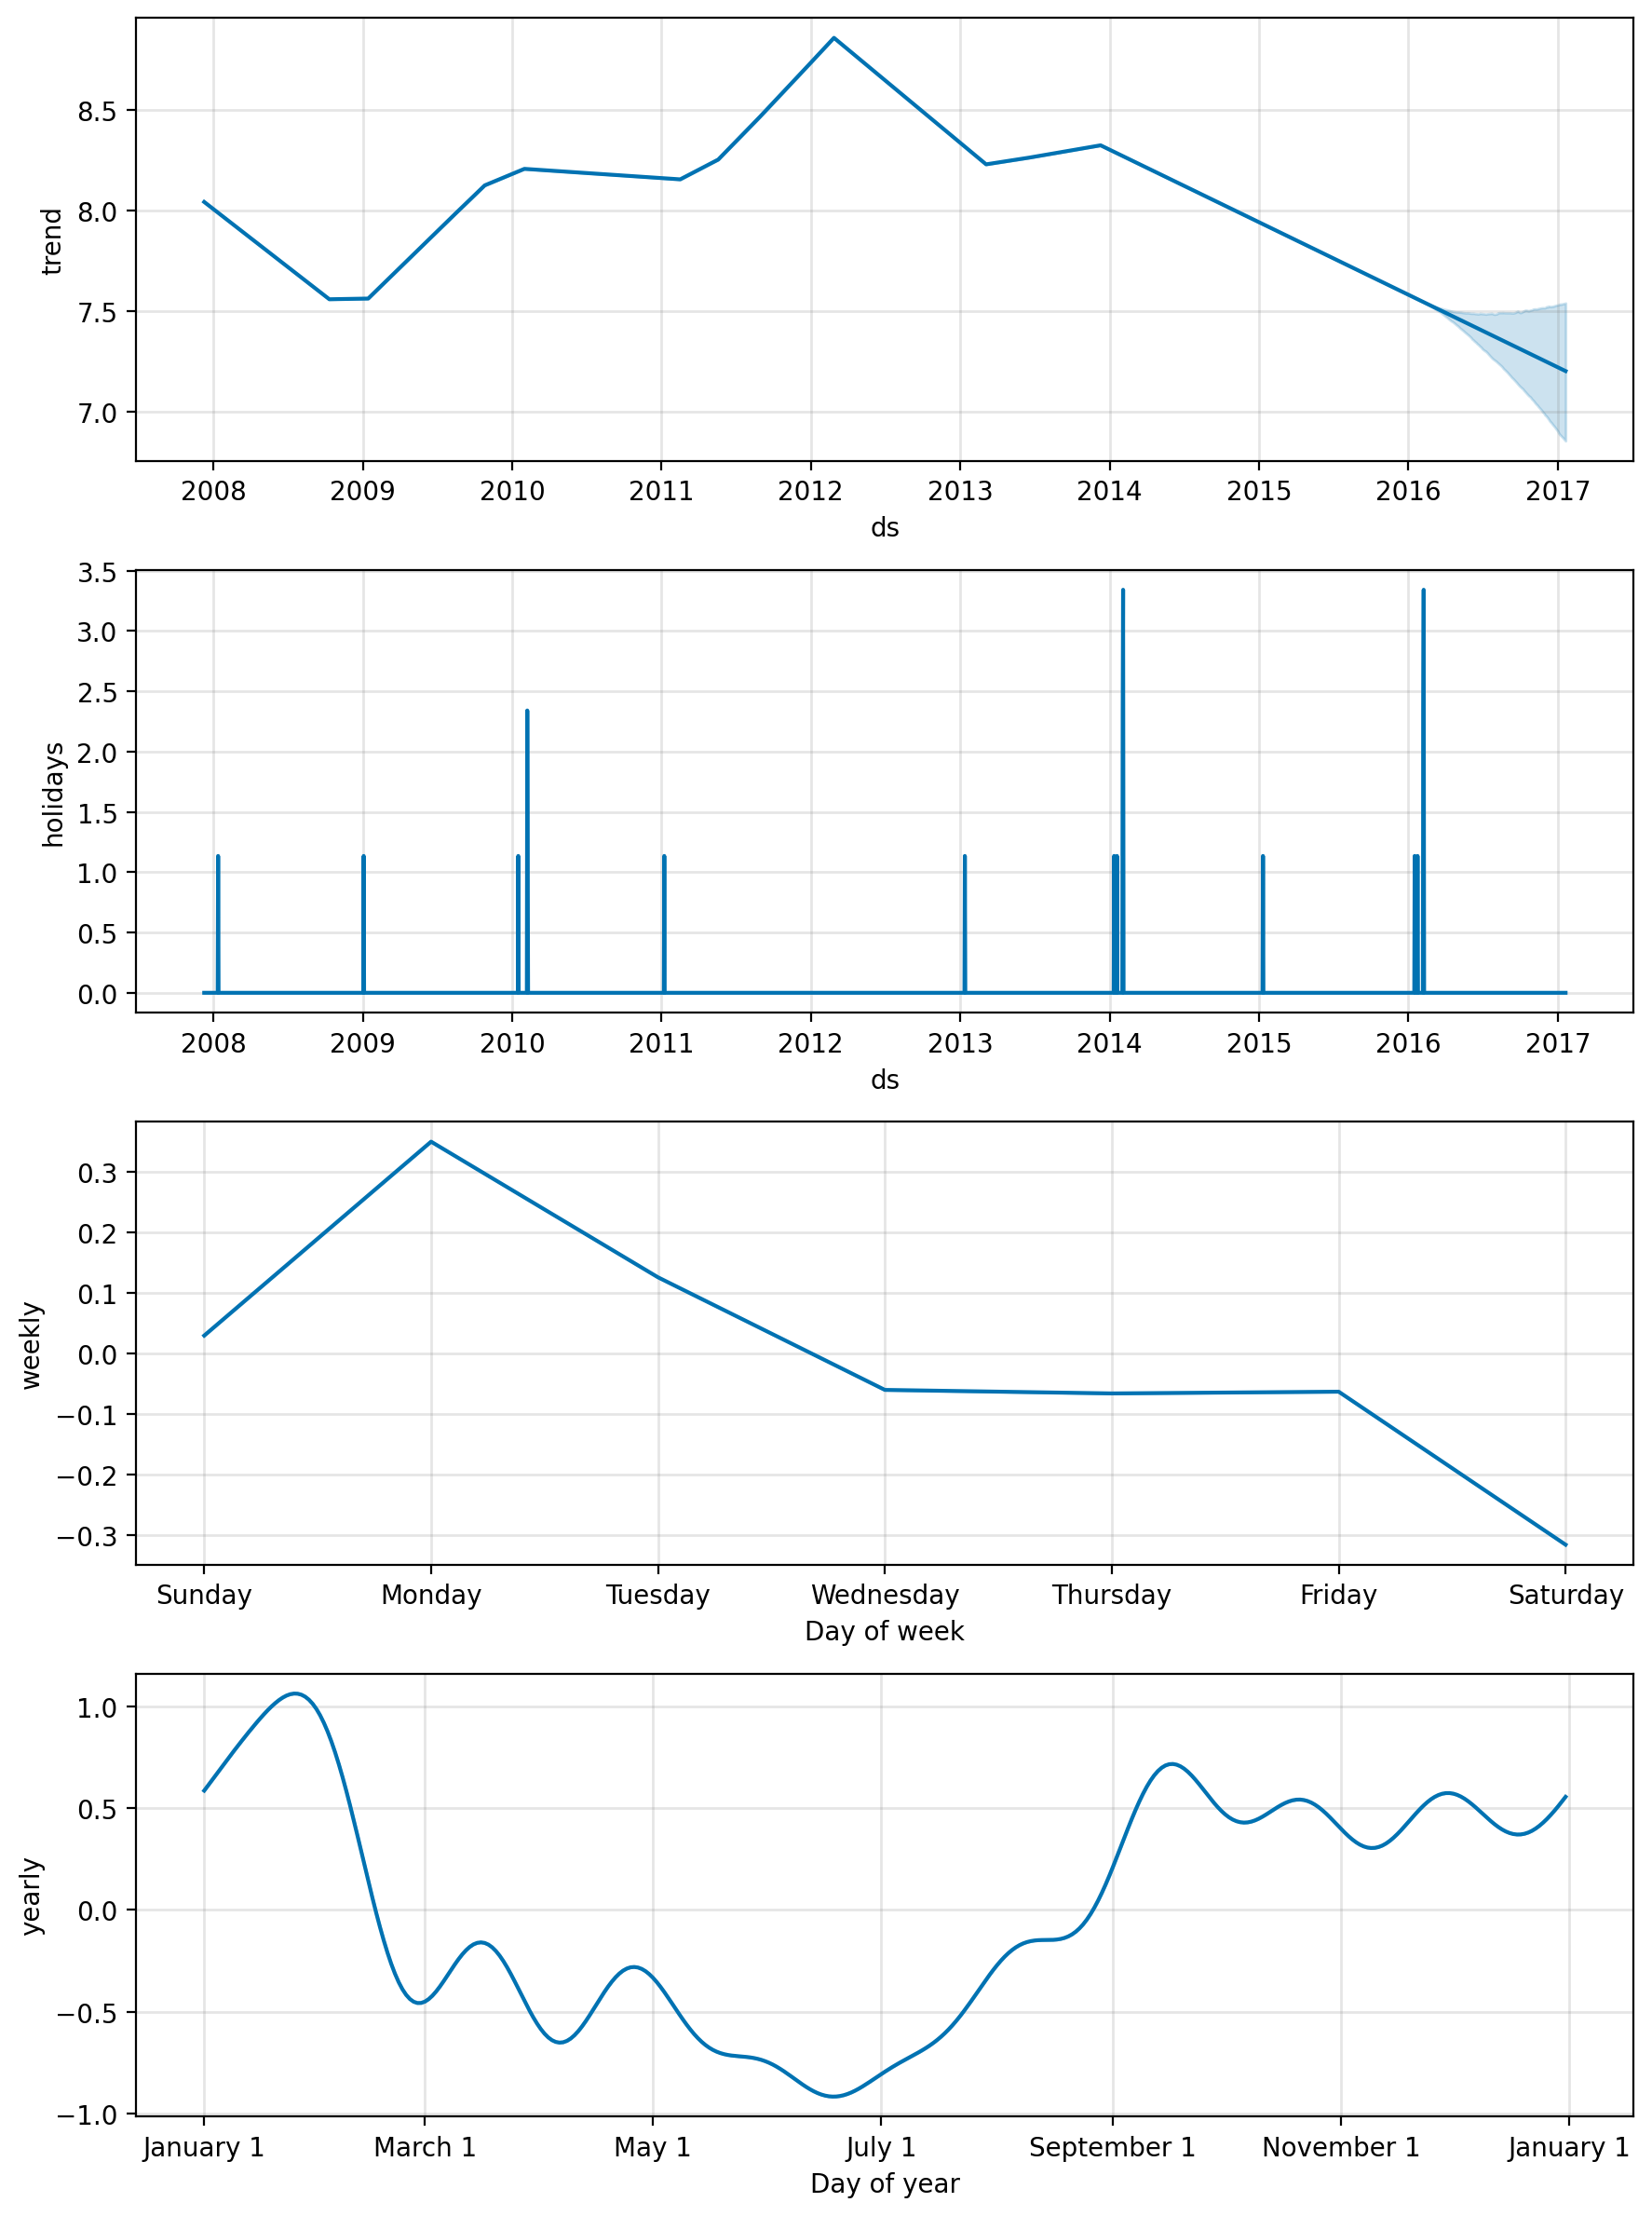

In [9]:
fig = m.plot_components(forecast)

#trend는 직선이나 곡선으로 바뀌는 부분?   끝에 하늘색 영역은 MAX~MIN 가능 범위의 영역을 지정해준 것. (상/하한선)


- 각 휴일은 `plot_forecast_component` 으로 그려볼 수 있다
- 특정 휴일만 보려면 `plot_forecast_component(m, forecast, 'superbowl')`

### 국경일 (내장)
- `add_country_holidays` 함수로 추가 지정 가능
- 한국 'KR'

In [10]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/xpvu9jf5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/hdcworn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9792', 'data', 'file=/tmp/tmpnu140hf4/xpvu9jf5.json', 'init=/tmp/tmpnu140hf4/hdcworn_.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_model0o57j_60/prophet_model-20230921013146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 포함된 휴일 보기
- `train_holiday_names`

In [11]:
m.train_holiday_names

0                         playoff
1                       superbowl
2      Martin Luther King Jr. Day
3           Washington's Birthday
4                    Columbus Day
5                  New Year's Day
6                    Memorial Day
7                Independence Day
8                       Labor Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

- 휴일은 `holidays` 파이썬 패키지가 제공한다
- 참조: https://github.com/dr-prodigy/python-holidays
- 확장하는 방법
https://github.com/facebook/prophet/blob/master/python/scripts/generate_holidays_file.py.

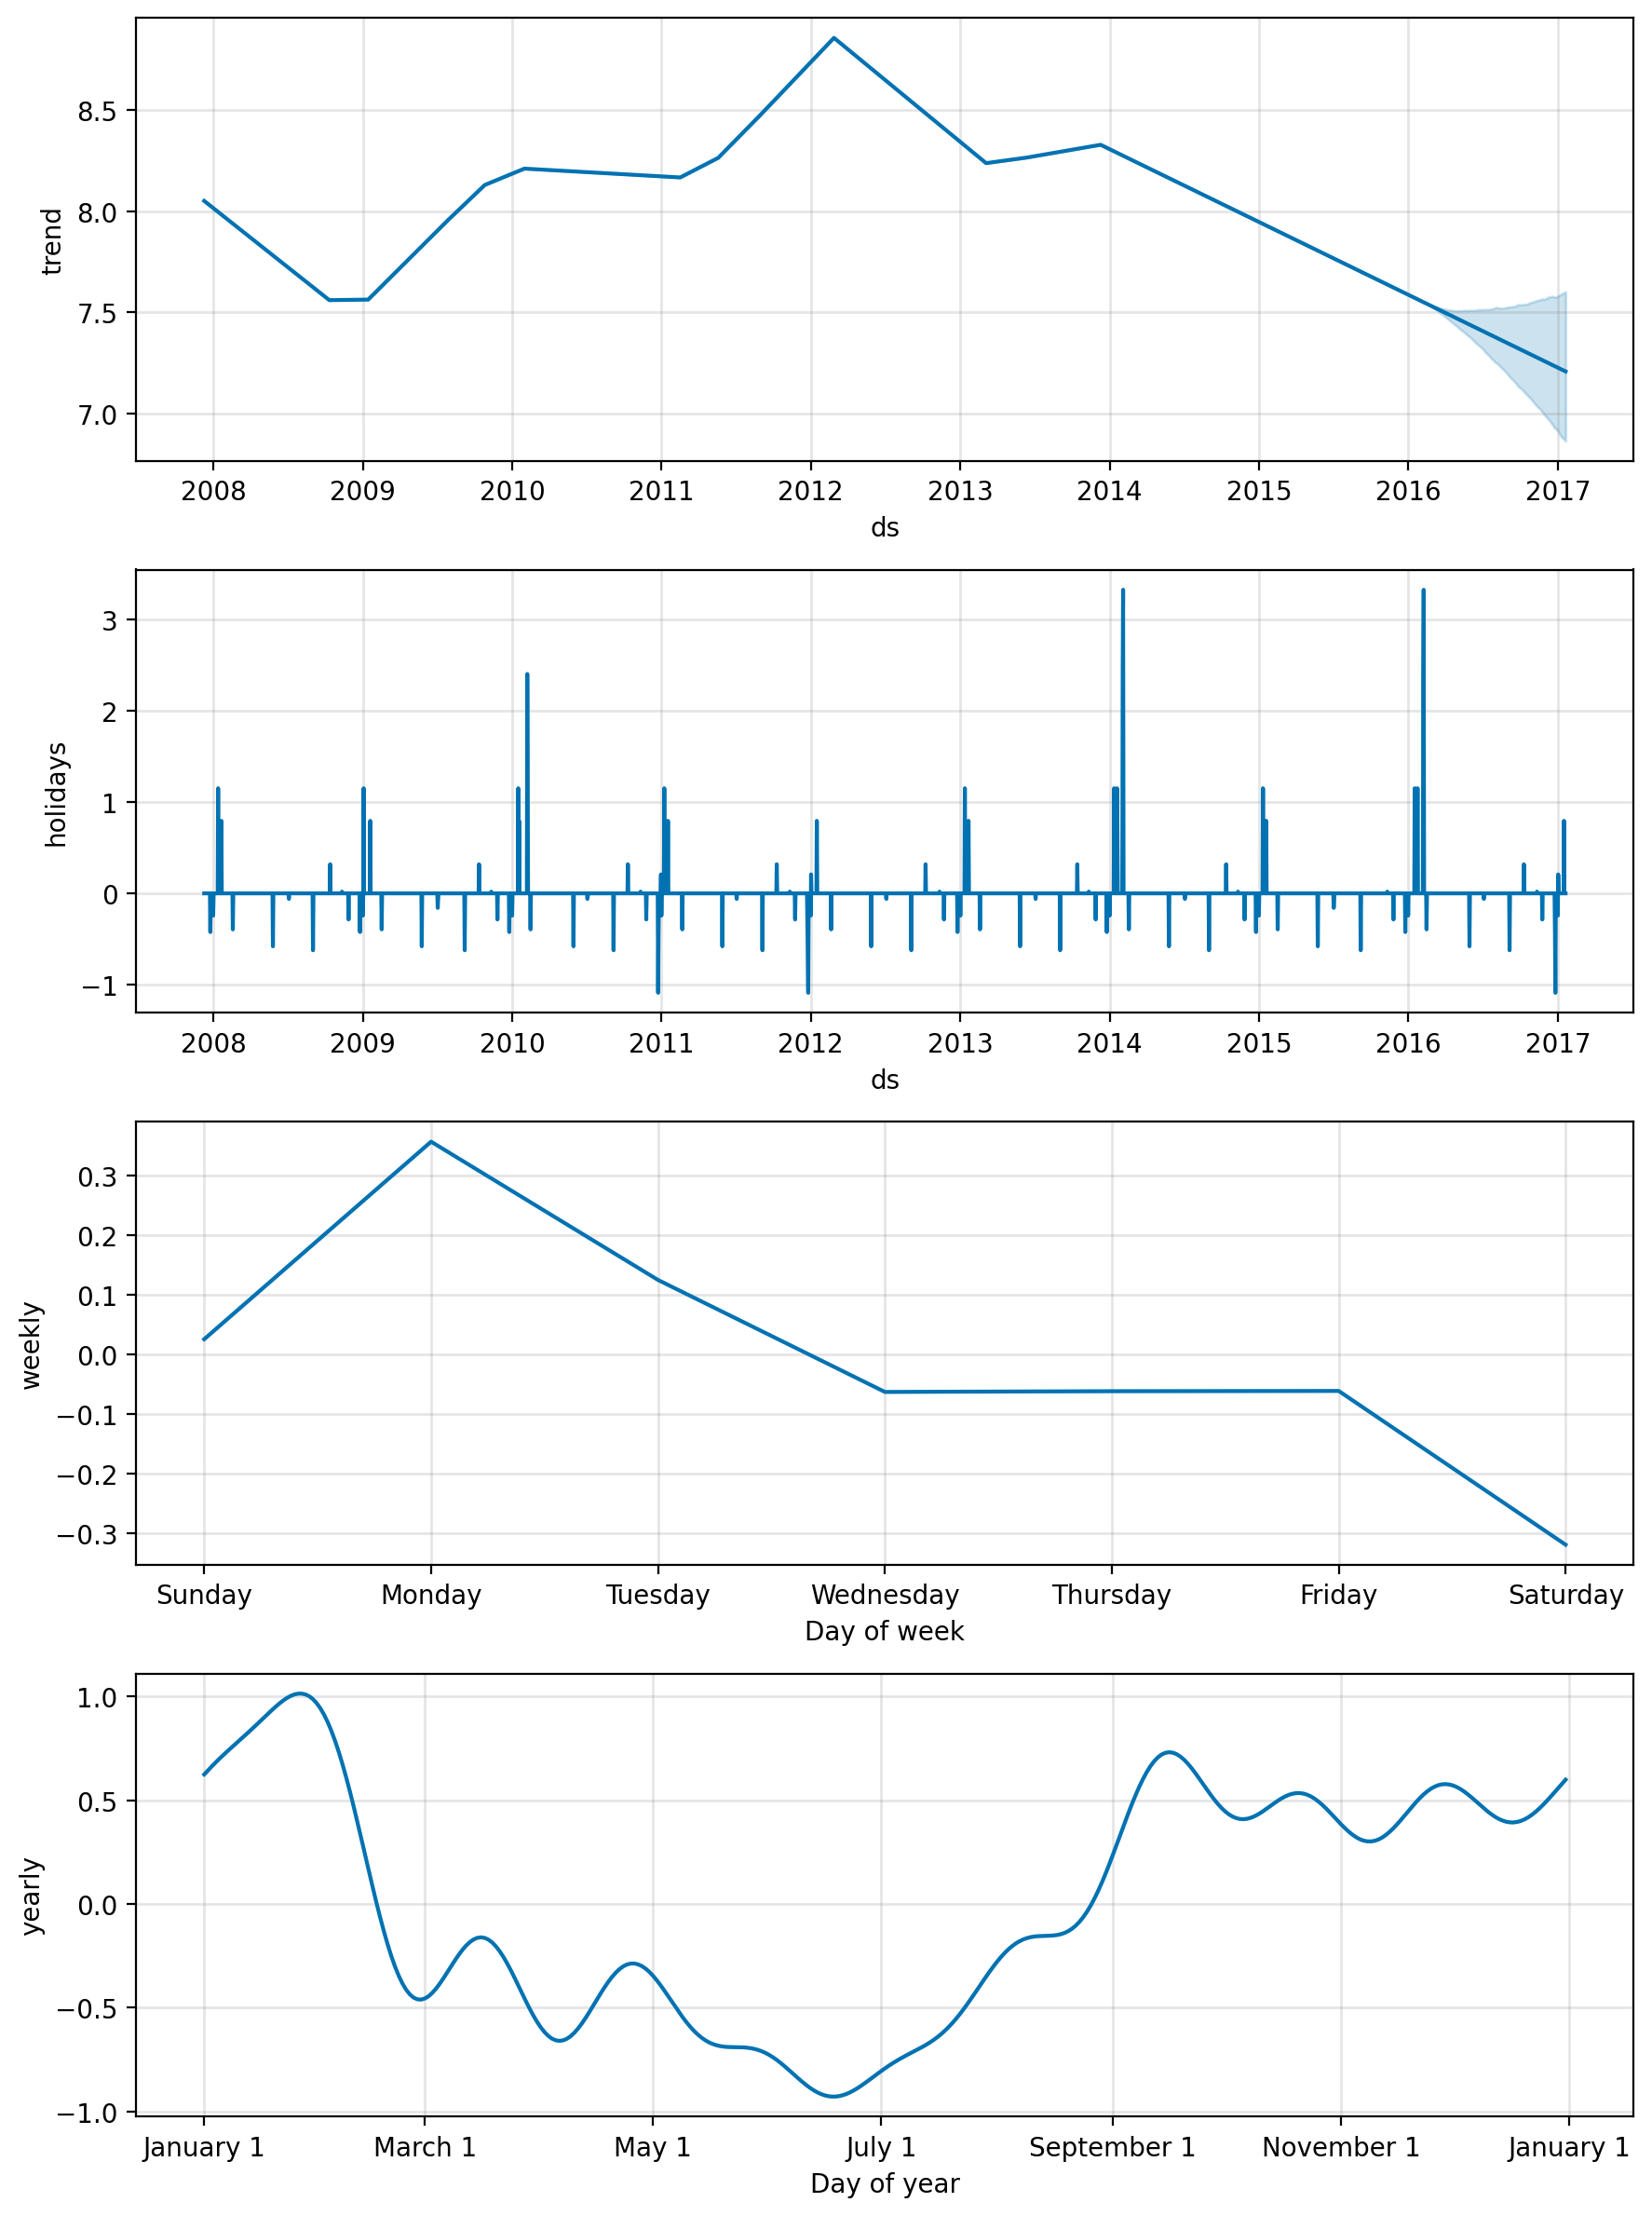

In [14]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

### 계절성은 주파수 분석으로
![image.png](attachment:image.png)

- 차원이 높을수록 빠른 변화를 표현할 수 있다.
- 연단위 계절성의 기본 값은 10, 주단위 계절성은 3

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/x5tn27hr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/q32wegjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24608', 'data', 'file=/tmp/tmpnu140hf4/x5tn27hr.json', 'init=/tmp/tmpnu140hf4/q32wegjh.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_modelj_qevq4t/prophet_model-20230921013358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


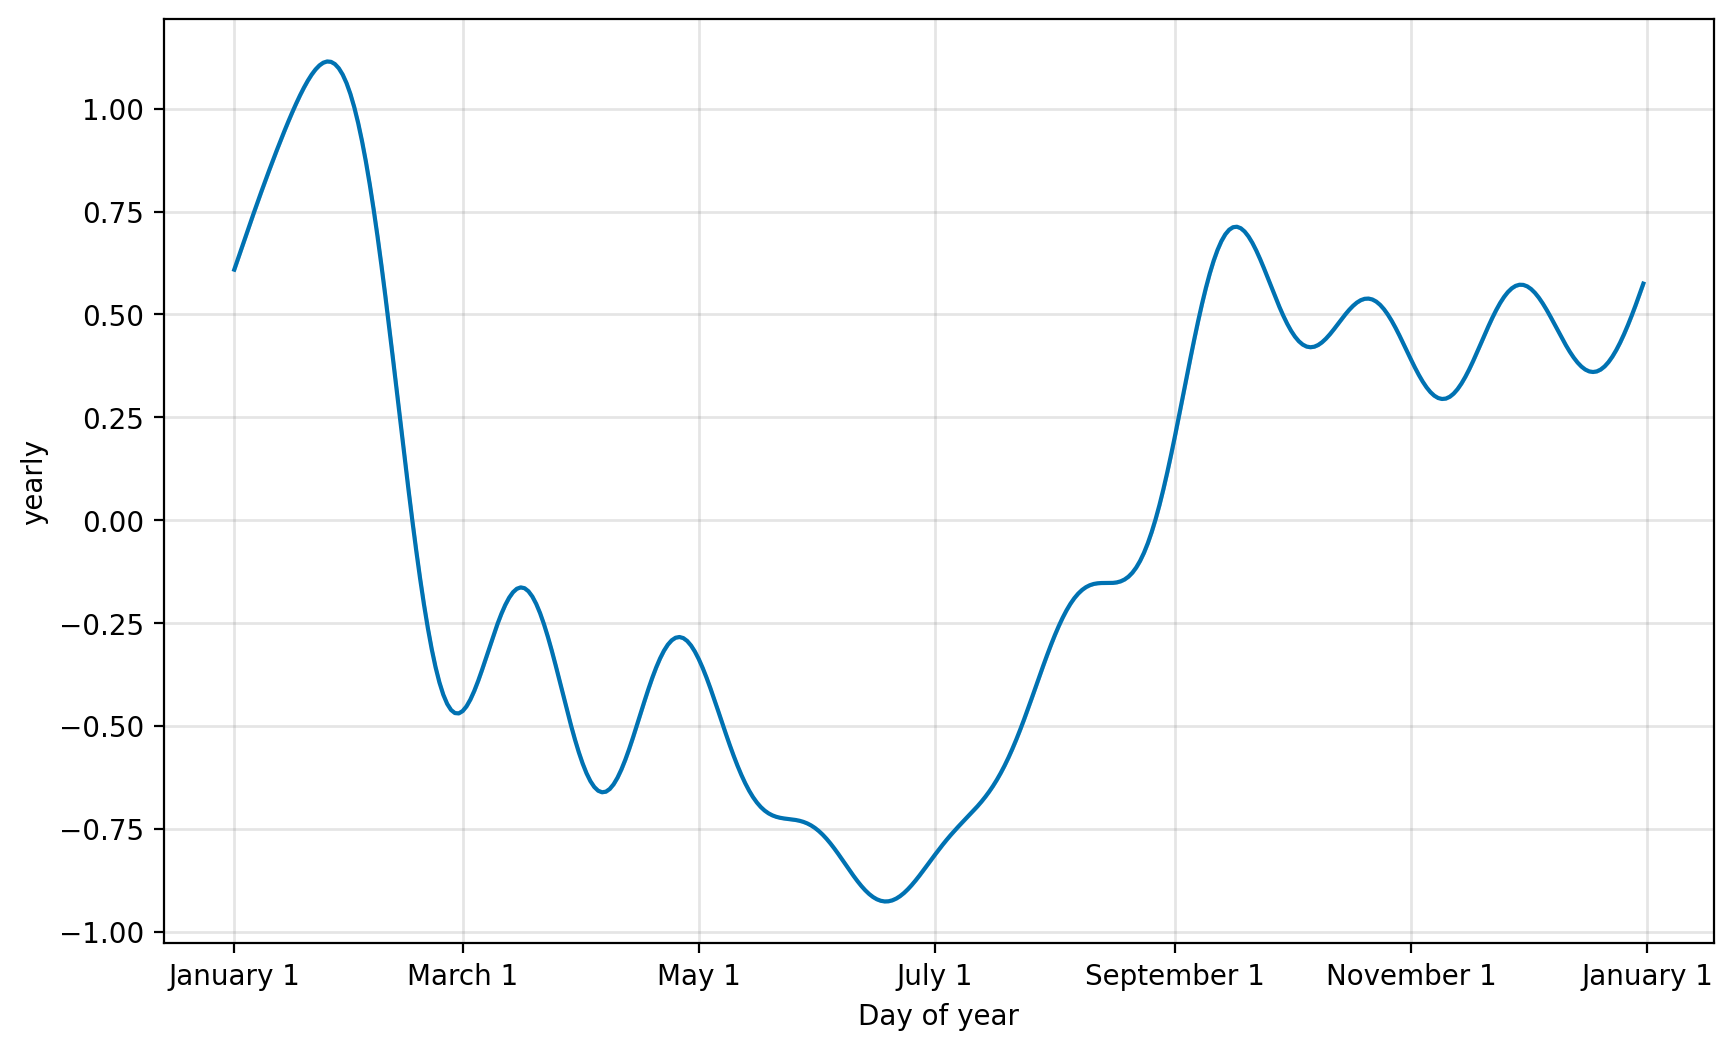

In [15]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

- 주파수 성분을 20으로 올린 경우 아래와 같다
- 과대적합이 될 수 있다

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/k410170n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/qi3afu3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32433', 'data', 'file=/tmp/tmpnu140hf4/k410170n.json', 'init=/tmp/tmpnu140hf4/qi3afu3n.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_modelpp6xpgfm/prophet_model-20230921013452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


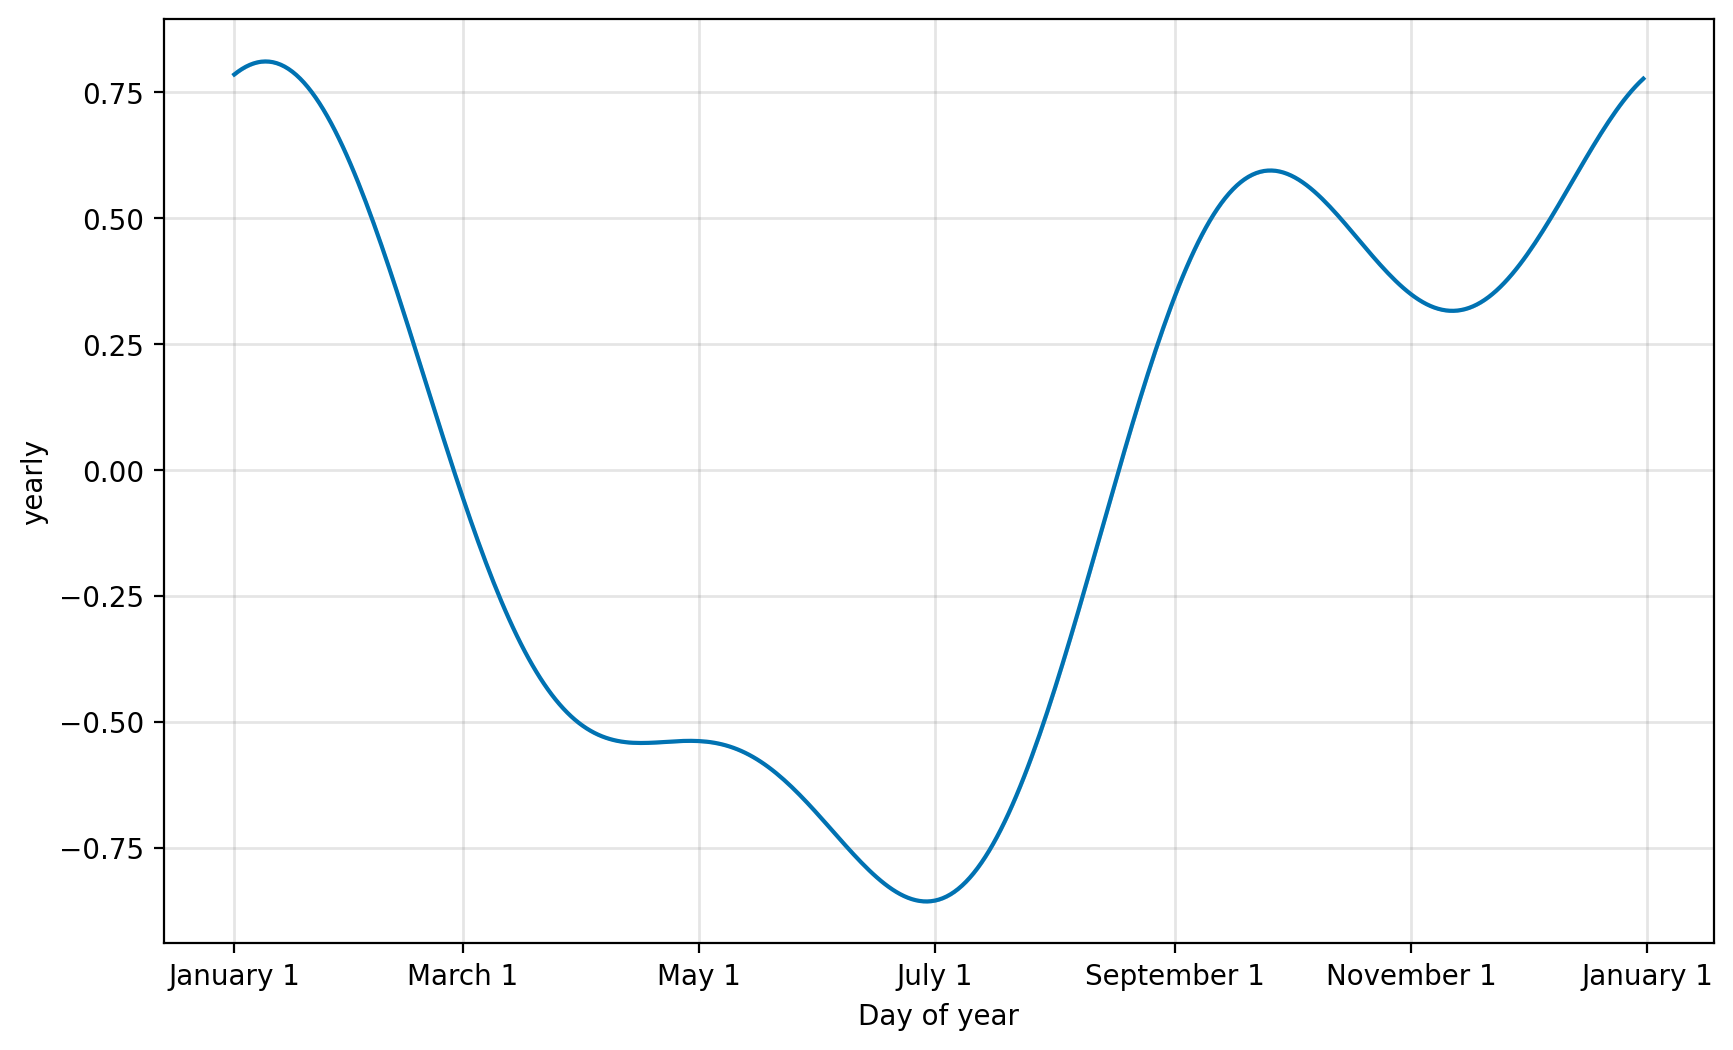

In [19]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=3).fit(df)
a = plot_yearly(m)

### 기타 계절성 지정

- Prophet은 기본적으로 주간 및 연간 계절성을 계산하며 최소한 2개의 주기가 필요하다.
- 하루 내의 주기성도 파악한다 (시간 단위 정보가 필요)
- 추가로, 월간, 분기별, 시간내의 주기성을 추가(또는 대체)할 수 있다. `add_seasonality` 사용
- prior scale을 지정할 수 있다
- 아래는 주단위 계절성을 월단위로 바꾼 경우

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/xvey_agg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/knb0_9wi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83247', 'data', 'file=/tmp/tmpnu140hf4/xvey_agg.json', 'init=/tmp/tmpnu140hf4/knb0_9wi.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_modelv29kpj5b/prophet_model-20230921013602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


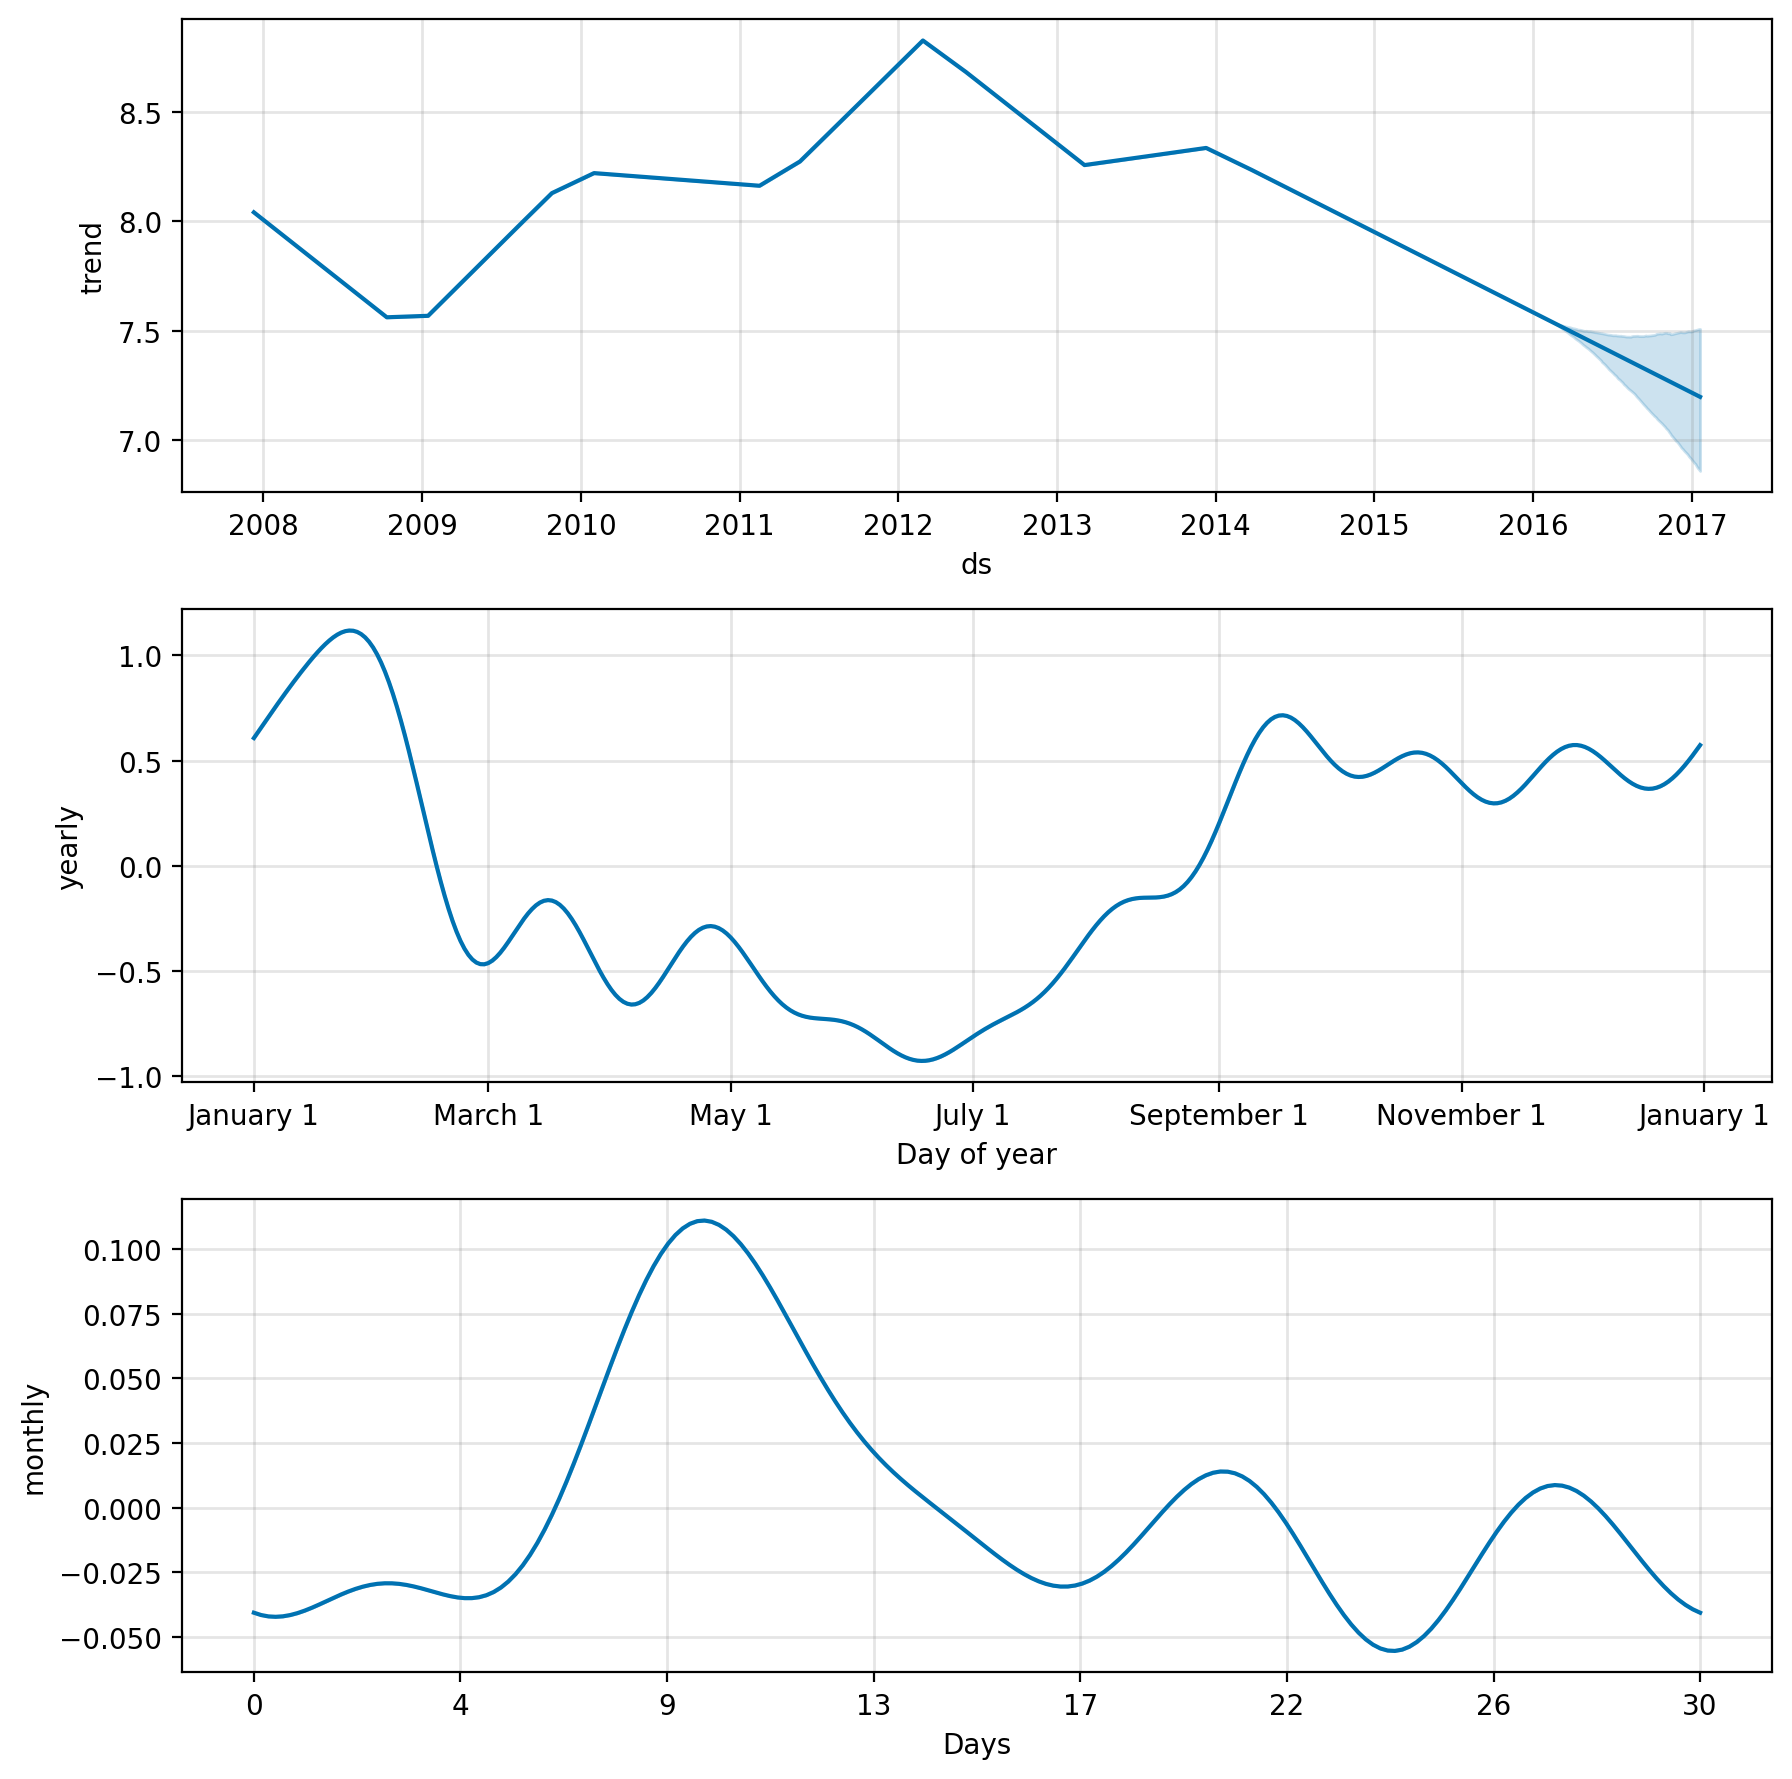

In [20]:
m = Prophet(weekly_seasonality=False)   #weekly 는 빼고 그리고, monthly 를 추가함.
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

### 조건부 계절성
- 주단위 계절성이 연중 다를 수도 있고, 일일 계절성도 요일에 따라 다를 수 있다
- 이를 위해 조건부 계절성을 지정할 수 있다
- 페이튼 매닝 데이터의 경우 주별 계절성은 "시즌"인가 아닌가에 따라 다르다 (시즌에는 일요일마다 게임)
- 시즌과 아닌 기간을 조건으로 달리하여 계절성을 반영할 수 있으려 이를 위해 불리언 컬럼을 사용한다

In [21]:
# 9월 이후 1월까지를 표시
# 9월~1월까지는 미국 national football League 에 대한 시즌을 적용. 그 외에는 시즌을 비적용.
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

In [ ]:
df*1  #True/False를 보지않으려고 곱함.

,ds,y,on_season,off_season
0,2007-12-10,9.590761,1,0
1,2007-12-11,8.519590,1,0
2,2007-12-12,8.183677,1,0
3,2007-12-13,8.072467,1,0
4,2007-12-14,7.893572,1,0
...,...,...,...,...
2900,2016-01-16,7.817223,1,0
2901,2016-01-17,9.273878,1,0
2902,2016-01-18,10.333775,1,0
2903,2016-01-19,9.125871,1,0


In [22]:
df  # *1 없음녀 True/False로 보임.

,ds,y,on_season,off_season
0,2007-12-10,9.590761,True,False
1,2007-12-11,8.519590,True,False
2,2007-12-12,8.183677,True,False
3,2007-12-13,8.072467,True,False
4,2007-12-14,7.893572,True,False
...,...,...,...,...
2900,2016-01-16,7.817223,True,False
2901,2016-01-17,9.273878,True,False
2902,2016-01-18,10.333775,True,False
2903,2016-01-19,9.125871,True,False


- 기존의 디폴트 주간 계절성을 disable시키고
- 조건이 있는 계절성으로 대체한다 (컬럼이 3개임)
- `condition_name` 컬럼이 `True`인 경우만 계절성을 적용한다
- 이를 `future` 데이터프레임에 반영해야 한다

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/6bidxt9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/pezey23p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99633', 'data', 'file=/tmp/tmpnu140hf4/6bidxt9u.json', 'init=/tmp/tmpnu140hf4/pezey23p.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_modelztjhzjcu/prophet_model-20230921021433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:14:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


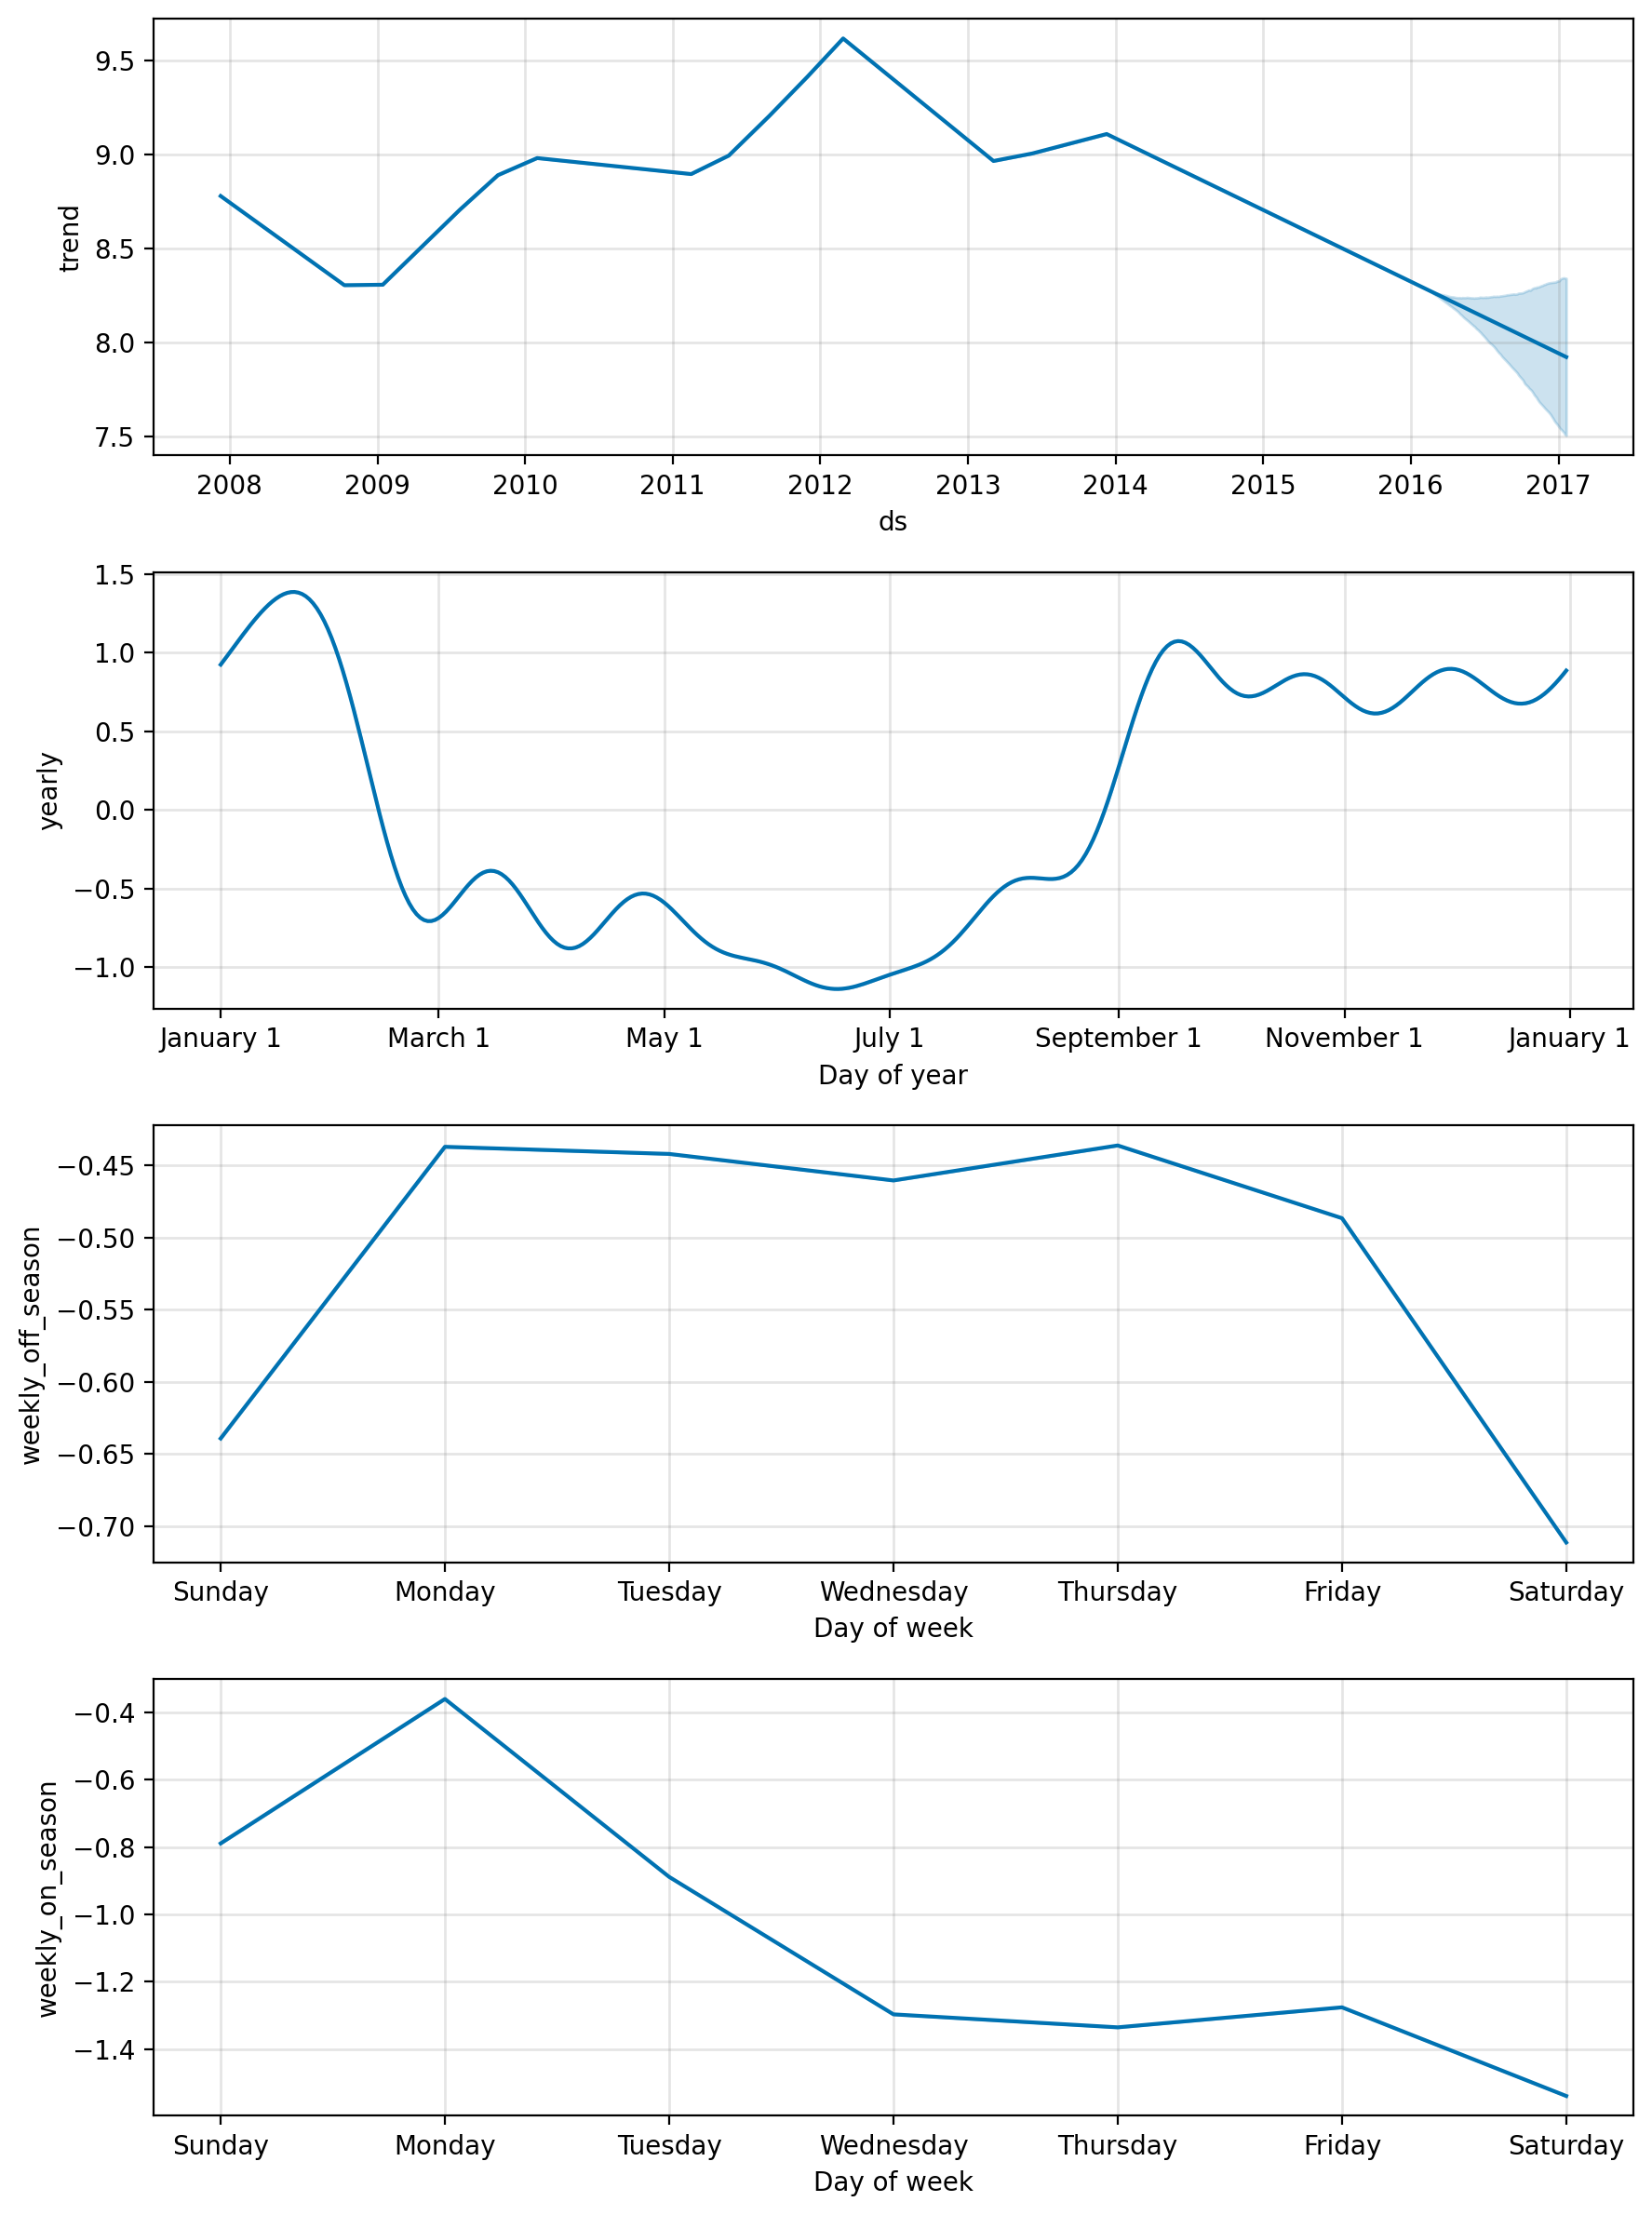

In [27]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=20, condition_name='on_season')
 # 새로운 시즌을 추가하는데,
 # period  7일마다 반복되며.
 # fouried_order 은 주파수에 대한 중첩 변수.  (3 은 기본값. 주파수들은 중첩될 수록 그 주파가 증폭되서 더 복잡해짐)
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=20, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

- 위의 결과를 보면 게임이 일요일에 있는 시즌에는 일요일, 월요일에 값이 증가하는 것을 알 수 있다

### Prior scale (휴일과 계절성)
- 휴일에서 과대적합이 발생하면 `holidays_prior_scale`을 조정하여 스무딩해야 한다
- 이값의 초기값은 10인데(작은 규제) 이를 줄이면 휴일 효과를 줄인다

- 요건 건너뛸게요~~~

In [ ]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,playoff,superbowl
2190,2014-02-02,1.205723,0.963130
2191,2014-02-03,1.851823,0.991663
2532,2015-01-11,1.205723,0.000000
2533,2015-01-12,1.851823,0.000000
2901,2016-01-17,1.205723,0.000000
2902,2016-01-18,1.851823,0.000000
2908,2016-01-24,1.205723,0.000000
2909,2016-01-25,1.851823,0.000000
2922,2016-02-07,1.205723,0.963130
2923,2016-02-08,1.851823,0.991663


- 이전에 비해서 휴일 효과가 줄어든 것을 알 수 있다 (특히 슈퍼볼에서)
- 같은 방법으로 계절성에서도 `seasonality_prior_scale` 으로 민감도를 줄일 수 있다
- Prior scales은 각각의 휴일에 대해서 지정할 수 있다. 이때 `prior_scale` 컬럼을 holidays 데이터프레임에서 사용한다.
- 각각의 휴일에 대한 스케일 값을 `add_seasonality` 인자로 넘겨준다
- 아래는 주간 계절성에 대해서만 적용하는 예이다

In [ ]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)


# (참고) 추가 회귀 (Additional regressors)
- 기존 선형 모델에 추가 회귀를 더할 수 있으며 `add_regressor` 함수를 사용한다
- 학습과 예측 데이터 프레임에 각각 추가하고자 하는 회귀값이 포함되어야 한다
- 아래는 NFL 시즌에 "일요일"의 효과를 추가하였다
- 효과는 'extra_regressors' plot으로 확인한다
- 요건 매우 중요함

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/r7piyvch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnu140hf4/p1bxx6le.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19367', 'data', 'file=/tmp/tmpnu140hf4/r7piyvch.json', 'init=/tmp/tmpnu140hf4/p1bxx6le.json', 'output', 'file=/tmp/tmpnu140hf4/prophet_model1eiubr11/prophet_model-20230921021328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


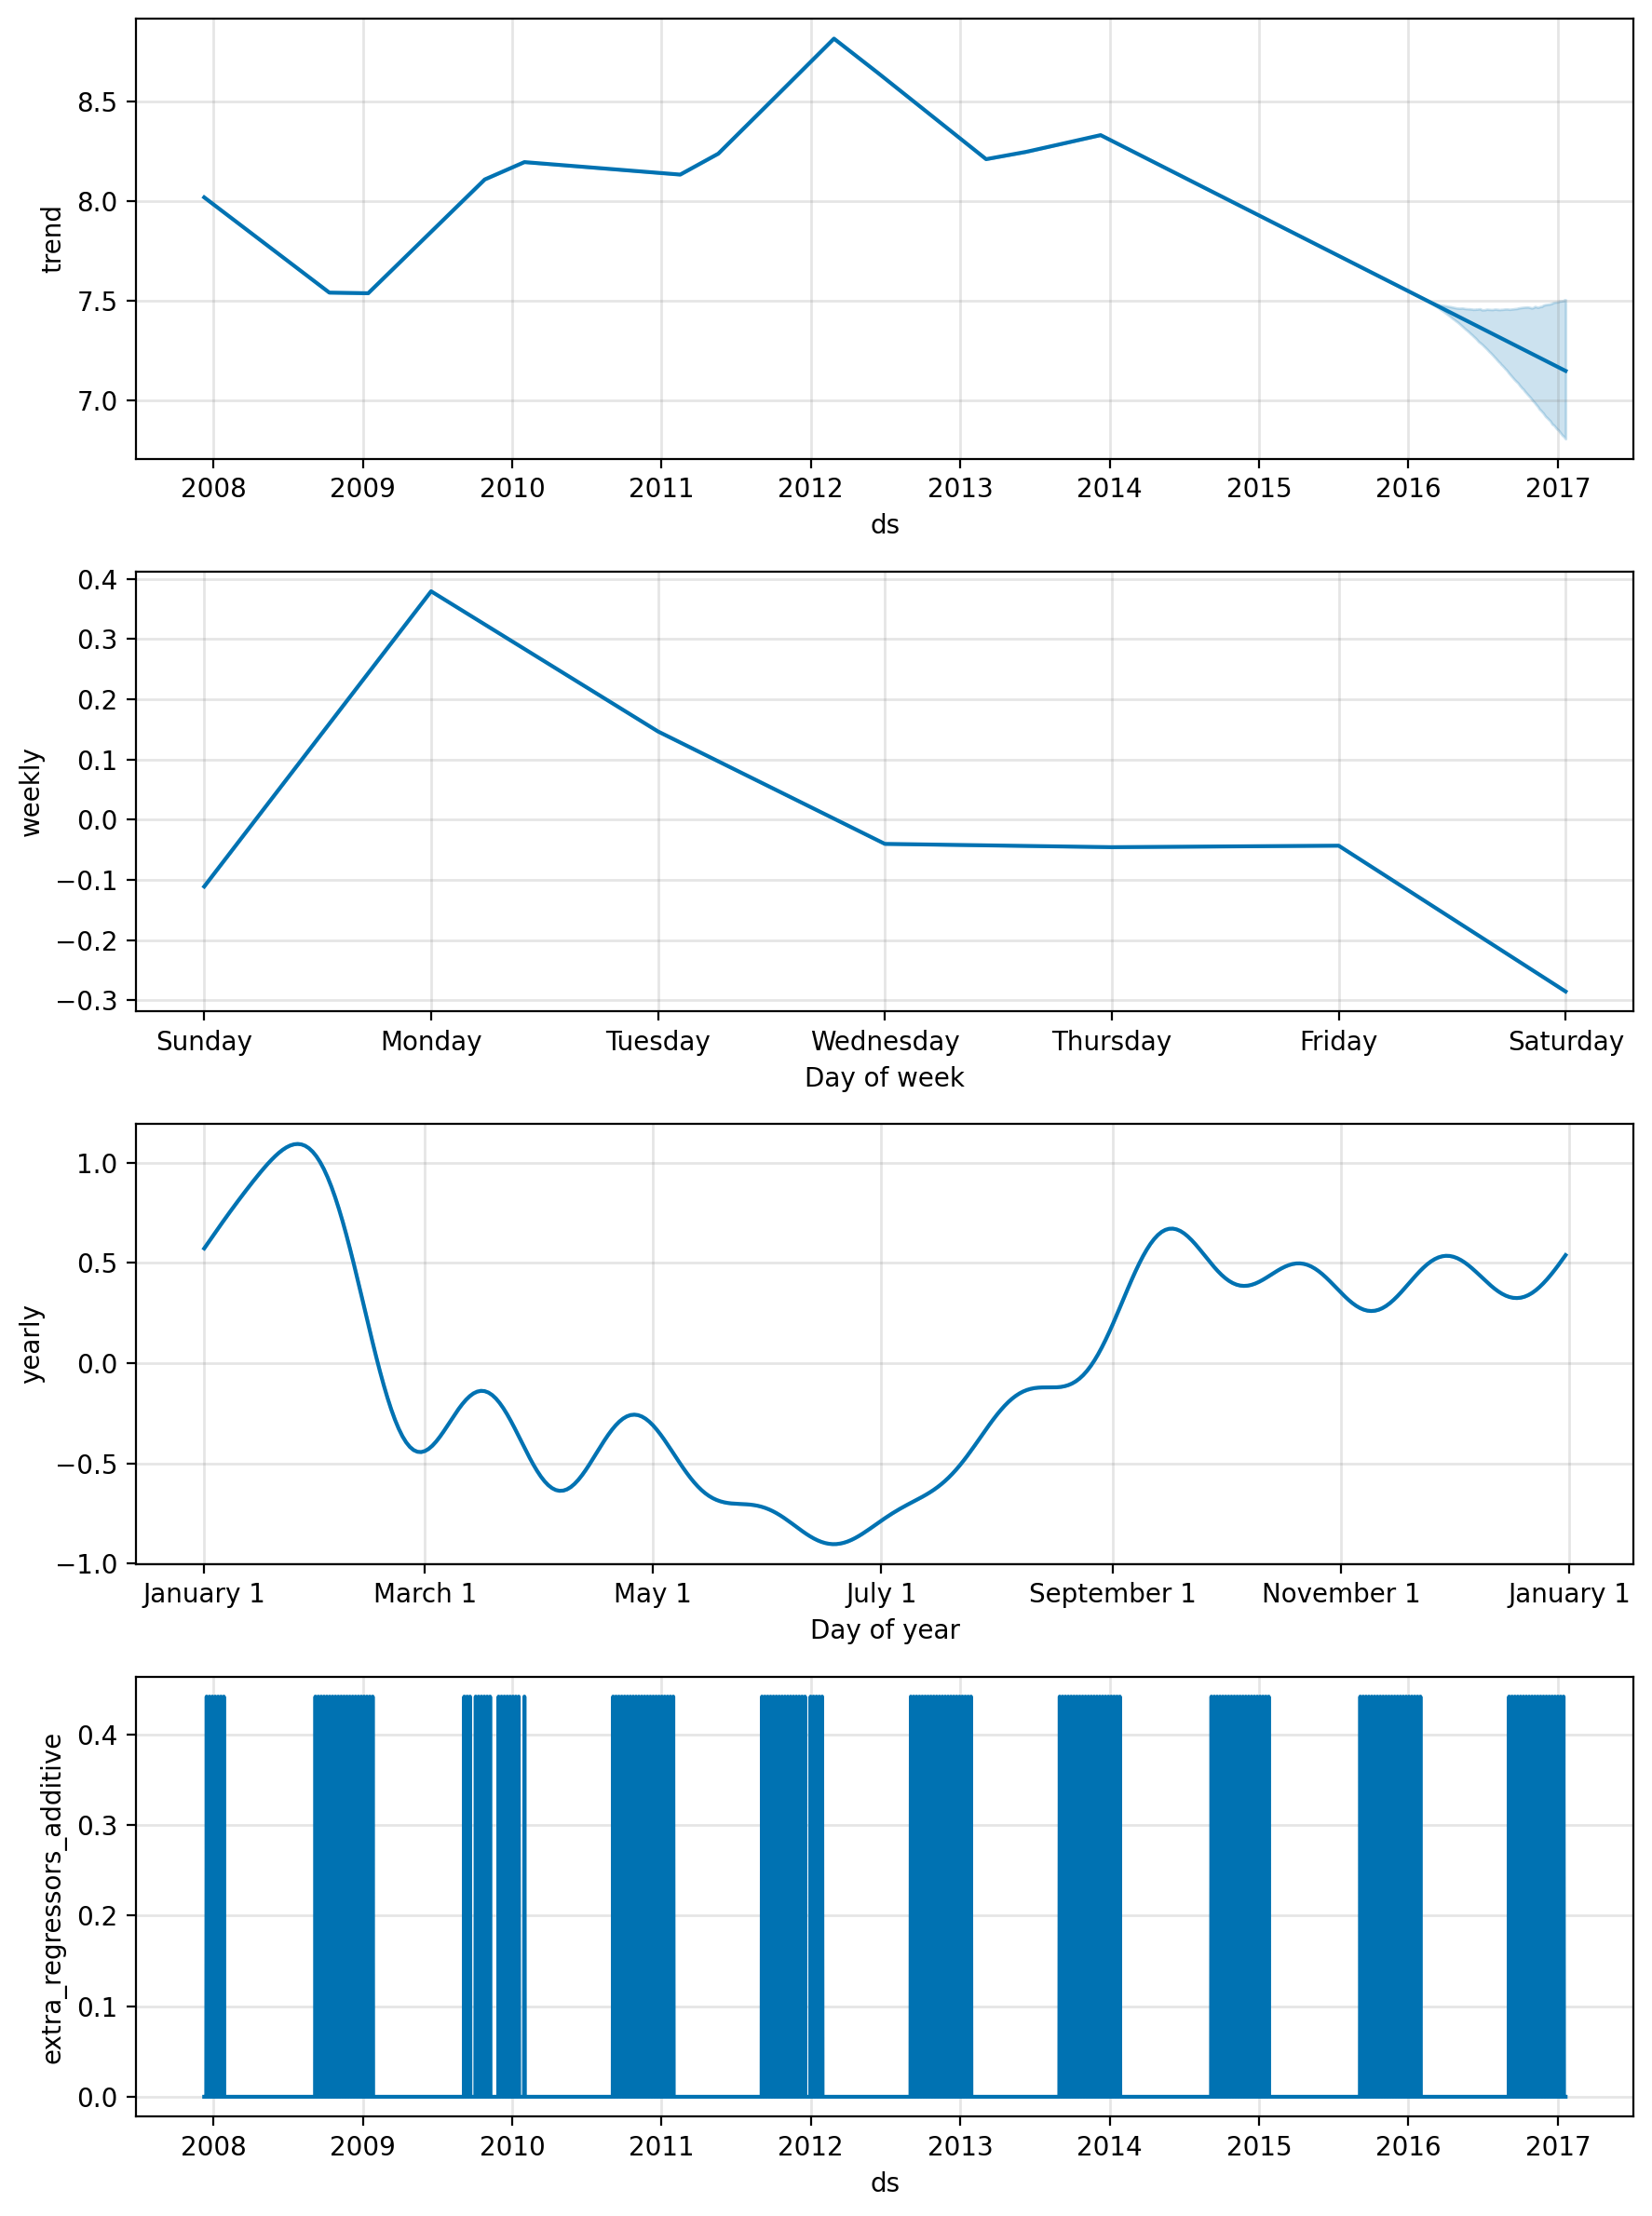

In [24]:
# 일요일인지를 확인 weekday()
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
# 웹사이트 클릭수에 대해 영향이 있는 컬럼이 있다고 간주하고, 그게 뭔지 모르니까 그냥 이름을 '일요일 효과' 라고 컬럼을 생성해둠.
# 이 말은 현재  y가 아니라, y에 영향을 주는 y2 가 잇으면 써줘라... (일요일이라서? 아니면 웹사이트 방문수? )
# prophet 는 사실 단변수 예측에 최적화가 되어있음.
# 단, 훈련데이터 자체에서도 y2를 추정해서 훈련을 하고, 이에 대한 이후 TEST를 진행하기떄문에 그에 대한 효과가..그닥.. 일단 가능은 합니다.
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

In [25]:
future.nfl_sunday.mean()

0.05992051360440232

- NFL기간의 Sundays는 "holidays"로 반영되었다
- 위에서는 일요일을 나타내는 카테고리 변수로 사용했으나 일반 연속 변수도 사용할 수 있다
- `add_regressor` 함수는 prior scale을 지정할 수 있다 (디폴트는 holiday prior scale)
- 정규화를 할지도 지정할 수 있다 `help(Prophet.add_regressor)` 참조
- 추가 회귀는 학습 전에 추가되어야 한다.
- 또한 future기간에도 필요하며, 이는 미래에 이 값을 알고 있어야만 한다. 또는 별도로 예측되어야 한다
- 별도의 Prophet 모델을 사용하기도 한다
- 주의할 것은 입력변수의 예측이 상당히 정확해야만 오차를 줄일 수 있다는 것이다
- 추가 회귀는 모델에서 "선형적"으로 반영된다

In [ ]:
# 과제: prophet 모델을 하나 실행해본다. 자신의 데이터를 사용하여, ds, y
# y를 다른 값을 바꾸어서 시도, 일 데이터를 주간평규치로 resampling하여 시도
# holiday 추가 (휴일 등 몇 개만 시도)
# 자신의 데이터가 없는 경우 위의 예제의 데이터 사용
# 기존의 예측 방법과 성능을 비교하시오 y_test, y_pred